# Anomaly Detection
In this notebook we will tackle the first problem of detecting credit card faud but without labels provided. 

In the real world, fraud often goes undiscovered, and onl the fraud that is caught provides any labels for the datasets. Moreover, fraud patterns change over time, so supervised systems that are built using fraud labels become stale, capturing historical patterns of fraud but failing to adapt to newly emerging patterns. 

We will build a solution using some of the dimensionality reduction algorithms from the other notebook and build from there. 

In [13]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
# Loading dataset
file = './datasets/credit_card_data/credit_card_data.csv'

data = pd.read_csv(file)

In [9]:
data_X = data.copy().drop(['Class'],axis=1) # dropping our labelled data 
data_y = data['Class'].copy()

In [11]:
data_X.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66


In [12]:
data_y.head(3)

0    0
1    0
2    0
Name: Class, dtype: int64

In [14]:
features_to_scale = data_X.columns
s_X = pp.StandardScaler(copy=True)

data_X.loc[:,features_to_scale] = s_X.fit_transform(data[features_to_scale])

In [16]:
# Getting split data with augmentation
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=2018, stratify=data_y)

### Defining Anomaly Score Function
We will now define a function that calculates how anomalous each transaction is. The more anomalous the transaction is, the more likely it is to be fraudulent, assuming that fraud is rare and looks somewhat different than the majority of transactions (normal transactions)

The algorithms will have the largest reconstruction error on those transactions that are hardest to model - in other words, those that occur the least often and are the most anomalous. 

Since fraud is rare and presumably different than normal transactions, the fraudulent transactions should exhibit the largest reconstruction error. 

We will therefor define the anomaly score as the reconstruction error. 

The reconstruction error for each transaction is the sum of the squared differences between the original feature matrix and the reconstructed matrix using the dimensionality reduction algorithm. 

We will scale the sum of the squared differences by the max-min range of the sum of the squared differences for the entire dataset, so that all reconstruction errors are within a zero to one range. 

The transactions that have the largest sum of squared differences will have an error close to one, while those that have the smallest sum of squared differences will have an error close to zero.

The dimensionality reduction algirithm will effectively assign each transaction an anomaly score between zero and one. Zero is normal and one is anomalous (most likely fraudulent) 

In [31]:
# Defining our function
def anomaly_Scores(original_DF, reduced_DF):
    loss = np.sum((np.array(original_DF)-np.array(reduced_DF))**2, axis=1)
    
    loss = pd.Series(data=loss, index=original_DF.index)
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
    
    return loss

### Defining Evaluation Metric
Given we have labels for our data, we will use this to score just how good our unsupervised learning algorithm performs

We will use precision-recall curve, the average position, and the auROC as our evaluation metric

In [20]:
# Defining evaluation metric function
def plot_Results(true_labels, anomaly_scores, return_preds=False):
    preds = pd.concat([true_labels, anomaly_scores], axis=1)
    preds.columns = ['True_Label', 'Anomaly_Score']
    
    precision, recall, threshold = precision_recall_curve(preds['True_Label'], preds['Anomaly_Score'])
    
    average_precision = average_precision_score(preds['True_Label'], preds['Anomaly_Score'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where="post")
    plt.fill_between(recall, precision, step="post", alpha=0.3, color="k")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"Precision Recall Curve: Average Precision = {average_precision}")
    
    fpr, tpr, threshold = roc_curve(preds['True_Label'], preds['Anomaly_Score'])
    
    area_under_ROC = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color="r", lw=2, label="ROC Curve")
    plt.plot([0,1], [0,1], color="k", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver operating characteristic: Area under the curve = {area_under_ROC}")
    plt.legend(loc="lower right")
    plt.show()
    
    if return_preds==True:
        return preds

In [22]:
# Defining plotting function
def scatter_plot(x_DF, y_DF, algo_name):
    temp_DF = pd.DataFrame(data=x_DF.loc[:,0:1], index=x_DF.index)
    temp_DF = pd.concat((temp_DF, y_DF), axis=1, join="inner")
    temp_DF.columns = ['First Vector', 'Second Vector', 'Label']
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=temp_DF, fit_reg=False)
    
    ax = plt.gca()
    ax.set_title(f"Seperation of Observations using {algo_name}")

### Normal PCA Anomaly Detection
We will use PCA to learn the underlying structure of the credit card transaction dataset. 

Once we learned this structure, we will use the learned model to reconstruct the credit card transactions and then calculate how different the reconstructed transactions are from the original transactions. 

Those transactions that PCA does the poorest jon of reconstructing are the most anomalous (most likely fraudulent)

**Anomaly detection relies on reconstruction error**. We want to the reconstruction error for rare transactions - the ones that are most likely to be fraudulent to be as high as possible and the reconstruction error for the rest to be as low as possible. 

for PCA, the reconstruction error will depend largely on the number of Principal Components we keep and use to reconstruct the original transactions. 

The more principle components we keep, the better PCA will be at learning the underlying structure of the original transactions. 

If we keep too many principal components, PCA may too easily reconstruct the original transactions, so much that the reconstruction error wil be minimal for all of transactions. If we keep too few principal components, PCA may mot be able to reconstruct any of the original transactions well enough, not normal nor fraudulent. 

We must therefor search for the right number of principal componetns to keep to build a good fraud detection system. 

In [23]:
from sklearn.decomposition import PCA

In [24]:
# PCA = number of original features
n_components = 30
whiten = False
random_state = 2018

In [25]:
pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

# Reconstructing the original transactions from PCA
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)

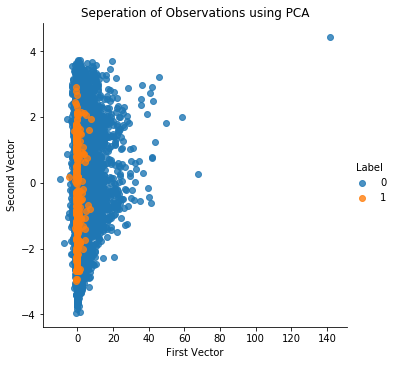

In [26]:
scatter_plot(X_train_PCA, y_train, "PCA")

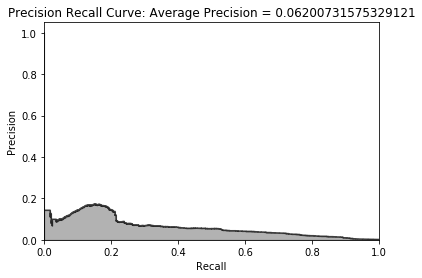

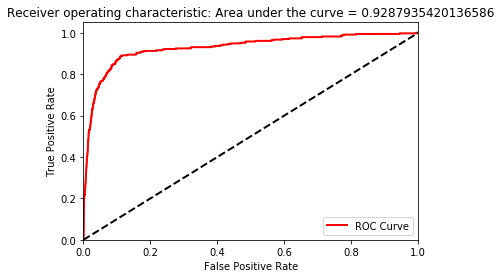

In [32]:
# Calculating precision-recall curve and ROC curve
anomaly_scores_PCA = anomaly_Scores(X_train, X_train_PCA_inverse)
preds = plot_Results(y_train, anomaly_scores_PCA, True)

with a Precision Recall Curve of 0.06, we catch close to no fraud. 

We need the PCA-based fraud detection solution to have enough error on the rare cases taht it can meaningfully seperate fraud cases from the normal ones. 

But the rror cannot be so low or so high for all transactions that the rare and normal transactions are virtually indistinguable. 

In [33]:
# PCA = 27
n_components = 27
whiten = False
random_state = 2018

In [34]:
pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

# Reconstructing the original transactions from PCA
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)

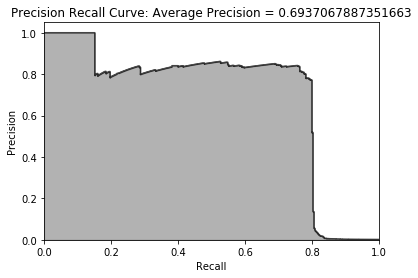

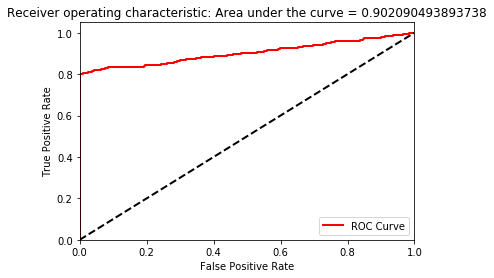

In [35]:
# Calculating precision-recall curve and ROC curve
anomaly_scores_PCA = anomaly_Scores(X_train, X_train_PCA_inverse)
preds = plot_Results(y_train, anomaly_scores_PCA, True)

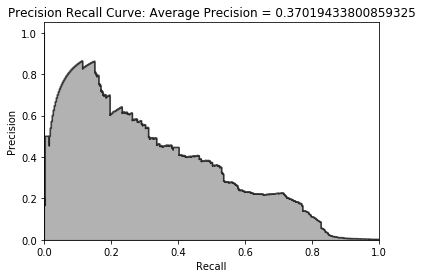

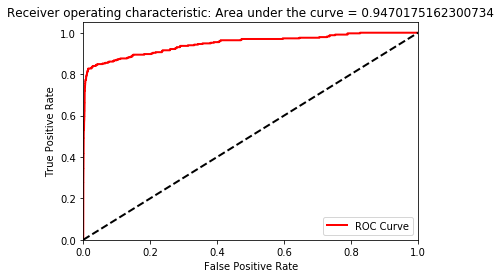

In [36]:
# PCA = 20
n_components = 20
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

# Reconstructing the original transactions from PCA
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)

# Calculating precision-recall curve and ROC curve
anomaly_scores_PCA = anomaly_Scores(X_train, X_train_PCA_inverse)
preds = plot_Results(y_train, anomaly_scores_PCA, True)

with **27** components, we are able to catch 80% of the fraud with 75% precision. 

## Sparse PCA Anomaly Detection
Sparse PCA is similar to normal PCA but delivers a less dense version; in other words, sparse PSA provides a sparse representation of the principal components 

Our alpha parameter will control the degree of sparsity. We will experiment with different values for the principal components and the alpha parameters as we search for the optimal sparse PCA fraud detection solution. 

In [38]:
from sklearn.decomposition import SparsePCA

In [39]:
n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1

In [40]:
sparse_PCA = SparsePCA(n_components=n_components, alpha=alpha, random_state=random_state, n_jobs=n_jobs)

In [41]:
sparse_PCA.fit(X_train.loc[:,:])

X_train_sparse_PCA = sparse_PCA.transform(X_train)
X_train_sparse_PCA = pd.DataFrame(data=X_train_sparse_PCA, index=X_train.index)

/Users/diegomedina-bernal/miniconda3/lib/python3.6/site-packages/sklearn/decomposition/sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


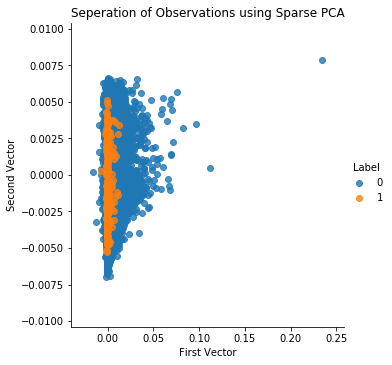

In [42]:
scatter_plot(X_train_sparse_PCA, y_train, "Sparse PCA")

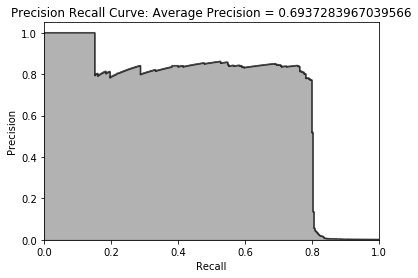

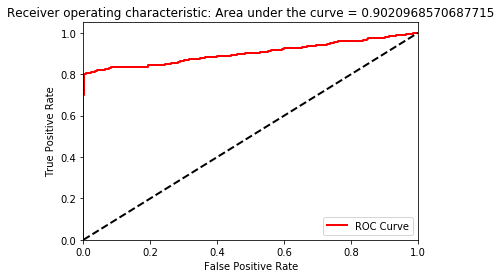

In [43]:
# Reconstructing 
X_train_sparse_PCA_inverse = np.array(X_train_sparse_PCA).dot(sparse_PCA.components_) + np.array(X_train.mean(axis=0))

X_train_sparse_PCA_inverse = pd.DataFrame(data=X_train_sparse_PCA_inverse, index=X_train.index)

anomaly_scores_sparse_PCA = anomaly_Scores(X_train, X_train_sparse_PCA_inverse)

preds = plot_Results(y_train, anomaly_scores_sparse_PCA, True)

## Kernal PCA Anomaly Detection
Now we will design a fraud detection solution using kernal PCA, which is a non-linear form of PCA and is useful if the fraud transactions are not linearly seperable from the non-fraud transactions. 

In [44]:
from sklearn.decomposition import KernelPCA

In [46]:
n_components = 27
kernel = "rbf"
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1

In [48]:
kernel_PCA = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, fit_inverse_transform=fit_inverse_transform, random_state=random_state, n_jobs=n_jobs)

In [50]:
kernel_PCA.fit(X_train.iloc[:2000])

X_train_kernel_PCA = kernel_PCA.transform(X_train)
X_train_kernel_PCA = pd.DataFrame(data=X_train_kernel_PCA, index=X_train.index)

X_train_kernel_PCA_inverse = kernel_PCA.inverse_transform(X_train_kernel_PCA)
X_train_kernel_PCA_inverse = pd.DataFrame(data=X_train_kernel_PCA_inverse, index=X_train.index)

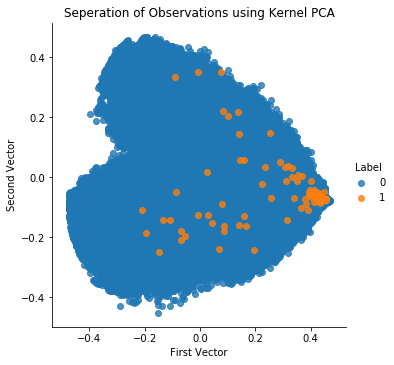

In [51]:
scatter_plot(X_train_kernel_PCA, y_train, "Kernel PCA")

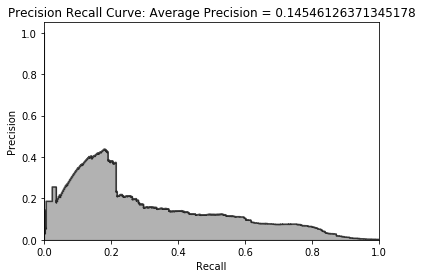

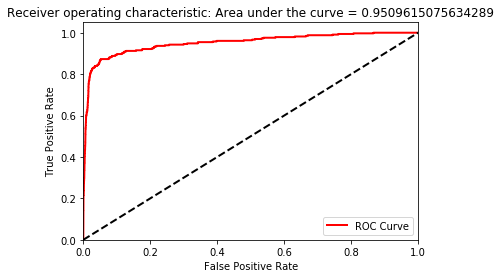

In [52]:
anomaly_scores_PCA = anomaly_Scores(X_train, X_train_kernel_PCA_inverse)
preds = plot_Results(y_train, anomaly_scores_PCA, True)

## Gaussian Random Projection Anomaly Detection
We will now move onto Gaussian Random projection. 

In [53]:
from sklearn.random_projection import GaussianRandomProjection

In [54]:
n_components = 27
eps = None
random_state = 2018

In [55]:
GRP = GaussianRandomProjection(n_components=n_components, eps=eps, random_state=random_state)

In [57]:
X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X_train.index)

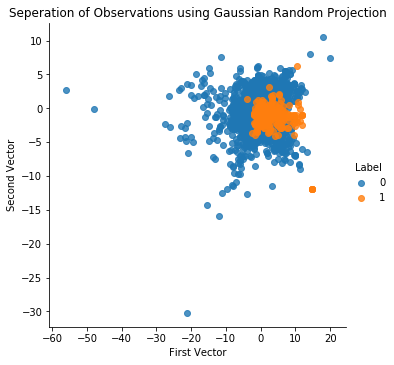

In [58]:
scatter_plot(X_train_GRP, y_train, "Gaussian Random Projection")

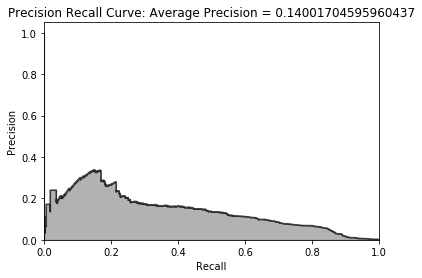

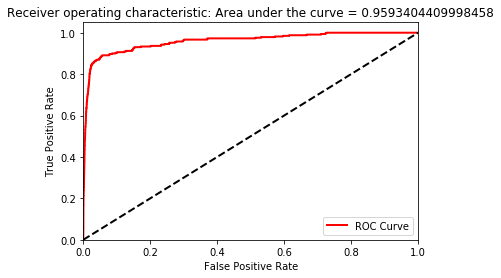

In [60]:
# Let's evaluate
X_train_GRP_inverse = np.array(X_train_GRP).dot(GRP.components_)
X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse, \
                                   index=X_train.index)

anomalyScoresGRP = anomaly_Scores(X_train, X_train_GRP_inverse)
preds = plot_Results(y_train, anomalyScoresGRP, True)

## Sparse Random Projection Anomaly Detections

In [61]:
from sklearn.random_projection import SparseRandomProjection

In [62]:
n_components = 27
density = "auto"
eps = .01
dense_output = True
random_state = 2018

In [63]:
SRP = SparseRandomProjection(n_components=n_components, density=density, eps=eps, dense_output=dense_output, random_state=random_state)

In [64]:
X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)

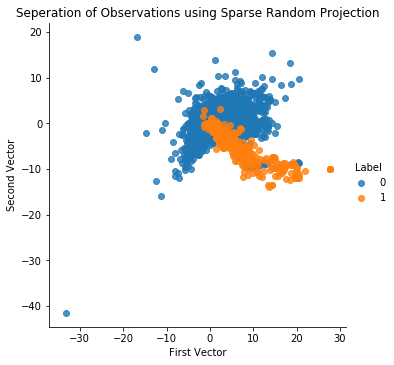

In [65]:
scatter_plot(X_train_SRP, y_train, "Sparse Random Projection")

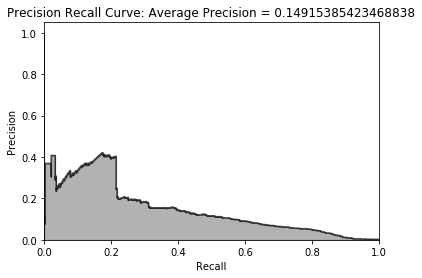

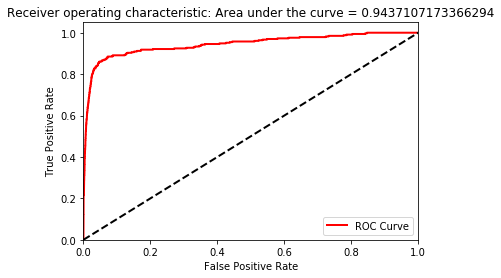

In [66]:
X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

anomalyScoresSRP = anomaly_Scores(X_train, X_train_SRP_inverse)
plot_Results(y_train, anomalyScoresSRP)

# Non-Linear Anomaly Detection
The above examples are all use linear dimensionality reduction methods: PCA, sparse PCA, Guassiant random projection, sparse random projection. 

With PCA being the best solution thus far. 

Given how inneficient these algorithms are (check dask and CuDF/ML for more efficient) 

We will switch to **nondistance-based dimensionality reduction methods**

## Dictionary Learning Anomaly Detection
In dictionary learning, the algorithm learns the sparse representation of the original data. Using the vectors in the learned dictionary, each instance in the original data can be reconstructed as a weighted sum of these learned vectors. 

For anomaly detection, we want to learn an unddercomplete dictionary so that the vectors in the dictionary are fewer in number than the original dimensions. 

With this constraint, it will be easier to reconstruct the more frequently occuring normal transactions and much more difficult to construct the rarer fraud transactions. 

We will generate 28 vectors to learn the dictionary, we will feed in 10 batches, where each batch has 200 samples 

In [67]:
from sklearn.decomposition import MiniBatchDictionaryLearning

In [68]:
n_components = 28
alpha = 1
batch_size = 100
n_iter = 10
random_state = 2018

In [69]:
mini_batch_dict_learning = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter, random_state=random_state)

In [70]:
mini_batch_dict_learning.fit(X_train)

X_train_mini_batch_learning = mini_batch_dict_learning.fit_transform(X_train)
X_train_mini_batch_learning = pd.DataFrame(data=X_train_mini_batch_learning, index=X_train.index)

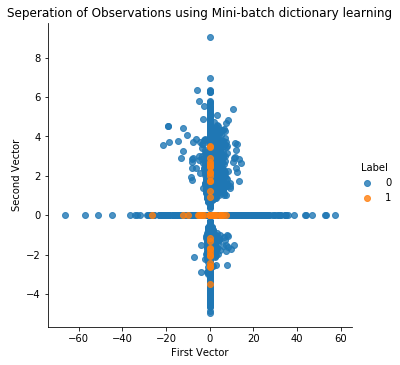

In [71]:
scatter_plot(X_train_mini_batch_learning, y_train, "Mini-batch dictionary learning")

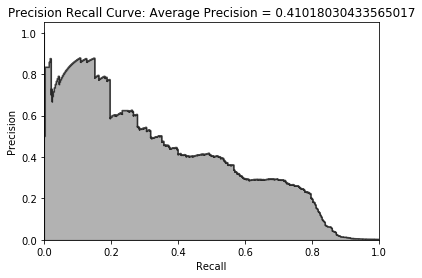

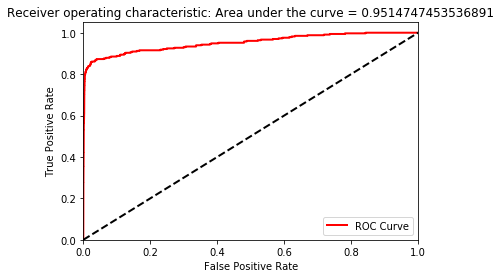

In [75]:
X_train_miniBatchDictLearning_inverse = \
    np.array(X_train_mini_batch_learning). \
    dot(mini_batch_dict_learning.components_)

X_train_miniBatchDictLearning_inverse = \
    pd.DataFrame(data=X_train_miniBatchDictLearning_inverse, \
                 index=X_train.index)

anomalyScoresMiniBatchDictLearning = anomaly_Scores(X_train, \
    X_train_miniBatchDictLearning_inverse)
preds = plot_Results(y_train, anomalyScoresMiniBatchDictLearning, True)

So far PCA remains the best

## ICA Anomaly Detection

In [76]:
from sklearn.decomposition import FastICA

In [77]:
n_components = 27
algorithm = "parallel"
whiten = True
max_iter = 200
random_state = 2018

In [78]:
fast_ICA = FastICA(n_components=n_components, algorithm=algorithm, whiten=whiten, max_iter=max_iter, random_state=random_state)

In [79]:
X_train_fast_ICA = fast_ICA.fit_transform(X_train)
X_train_fast_ICA = pd.DataFrame(data=X_train_fast_ICA, index=X_train.index)

X_train_fast_ICA_inverse = fast_ICA.inverse_transform(X_train_fast_ICA)
X_train_fast_ICA_inverse = pd.DataFrame(data=X_train_fast_ICA_inverse, index=X_train.index)

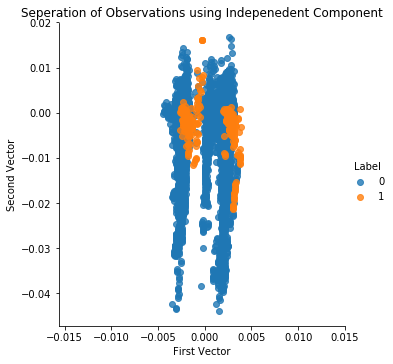

In [80]:
scatter_plot(X_train_fast_ICA, y_train, "Indepenedent Component")

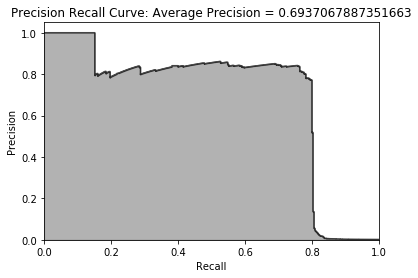

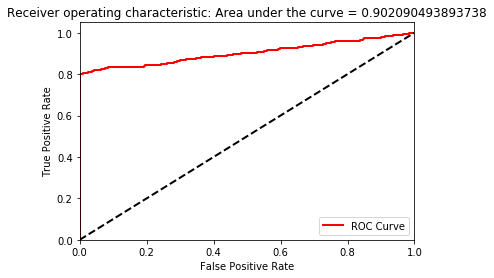

In [82]:
anomalyScoresFastICA = anomaly_Scores(X_train, X_train_fast_ICA_inverse)
plot_Results(y_train, anomalyScoresFastICA)

# Testing On Test Set
Now, we will evaluate our fraud detection solutions by using never-before-seen test datasets. 

We will test the top three solutions:
1. Normal PCA
2. ICA
3. Dictionary Learning

In [83]:
# Normal PCA
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, index=X_test.index)

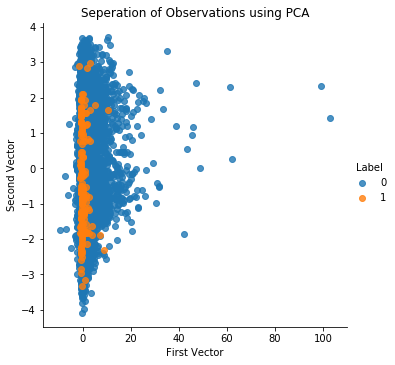

In [84]:
scatter_plot(X_test_PCA, y_test, "PCA")

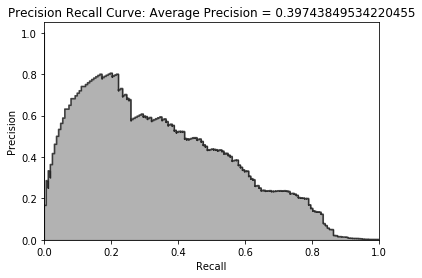

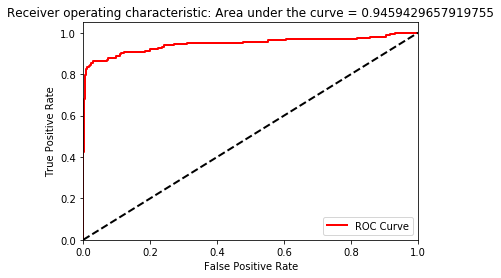

In [85]:
anomalyScoresPCA = anomaly_Scores(X_test, X_test_PCA_inverse)
preds = plot_Results(y_test, anomalyScoresPCA, True)